## Machine Learning Exercise

### Regression Neural Network

### Chicago Crime and Socio Economic Data

This project uses crime data from the Chicago Data Portal and Socioeconomic Data fro the Chicago Department of Health

**The dependent or target variable is number of crimes per category:  month, community area, primary type**
>Crime data is from calendar year 2012 and is aggregated as number of crimes by calendar month, community area, and primary crime type

**The features or independent variables are**
>Socioeconomic data from the Chicago Department of Health and represents aggregated statistics for calendar years 2008 through 2012
- The percent of occupied housing units with more than one person per room (i.e., crowded housing)
- The percent of households living below the federal poverty level
- The percent of persons in the labor force over the age of 16 years that are unemployed
- The percent of persons over the age of 25 years without a high school diploma
- The percent of the population under 18 or over 64 years of age (i.e., dependency)
- Per capita income
- Hardship Index

Create a regression machine learning model that will predict the level of crimes by calendar month, community area, and primary crime type based on an increase or decrease in the relevant socioeconomic indicators


In [31]:
# local Operating System
import os

# Match and Science
import numpy as np
np.random.seed(123) # for reproducability
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import sklearn

# Machine Learning
import tensorflow as tf
import keras

# Visualisation
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Dataframe
import pandas as pd

# SQL - PostgreSQL
import bq_helper

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import plot_model

from numpy import array
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from shapely.geometry import Point, Polygon
from bq_helper import BigQueryHelper

**The Chicago Crime Data dataset is hosted on Google Big Query**

In [32]:
chicago_crime = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="chicago_crime") 

Using Kaggle's public dataset BigQuery integration.


**Query total crimes by Community Area**

In [33]:
city_sql_commarea = """
WITH cr AS
(
    SELECT DISTINCT
    community_area
    , COUNT(*) AS crimes 
    FROM  `bigquery-public-data.chicago_crime.crime`
    WHERE year = 2012
    GROUP BY community_area
)
SELECT 
cr.crimes
, cr.community_area
FROM cr
ORDER BY cr.crimes DESC, cr.community_area
"""
chicri_commarea = chicago_crime.query_to_pandas(city_sql_commarea)

**Load the Chicago Health and Human Services Socio-Economic Stats**

In [34]:
chipop_df = pd.read_csv('../input/Chicago_Census_SociaEcon_CommArea_2008_2012.csv')
chipop_columns = [
'community_area',
'community_area_name', 
'pct_housing_crowded', 
'pct_households_below_poverty', 
'pct_age16_unemployed',
'pct_age25_nohighschool',
'pct_not_working_age',
'per_capita_income',
'hardship_index']
chipop_df.columns = chipop_columns


## Visulaize the Data

**Merge the two sets together joining on Community Area**

In [35]:
chicri_commarea = pd.merge(chicri_commarea, chipop_df, on='community_area', how='inner')
chicri_commarea = chicri_commarea.dropna(inplace=False) 

**Filter Columns for Charting**

In [36]:
chicri_commarea_df = chicri_commarea[['community_area_name',
                                'pct_housing_crowded',
                                'pct_households_below_poverty',
                                'pct_age16_unemployed',
                                'pct_age25_nohighschool',
                                'pct_not_working_age',
                                'per_capita_income',
                                'hardship_index',
                                'crimes']]

**Univariate Scatter Plots Between all the 6 features and the target with distribution for each on the diagonal**
The Socio-Economic indicators are all highly correlated and probably exhibit some auto correlation.
On the bottom row we can observe some structure between crimes and the 6 Socio-Economic indicators.


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


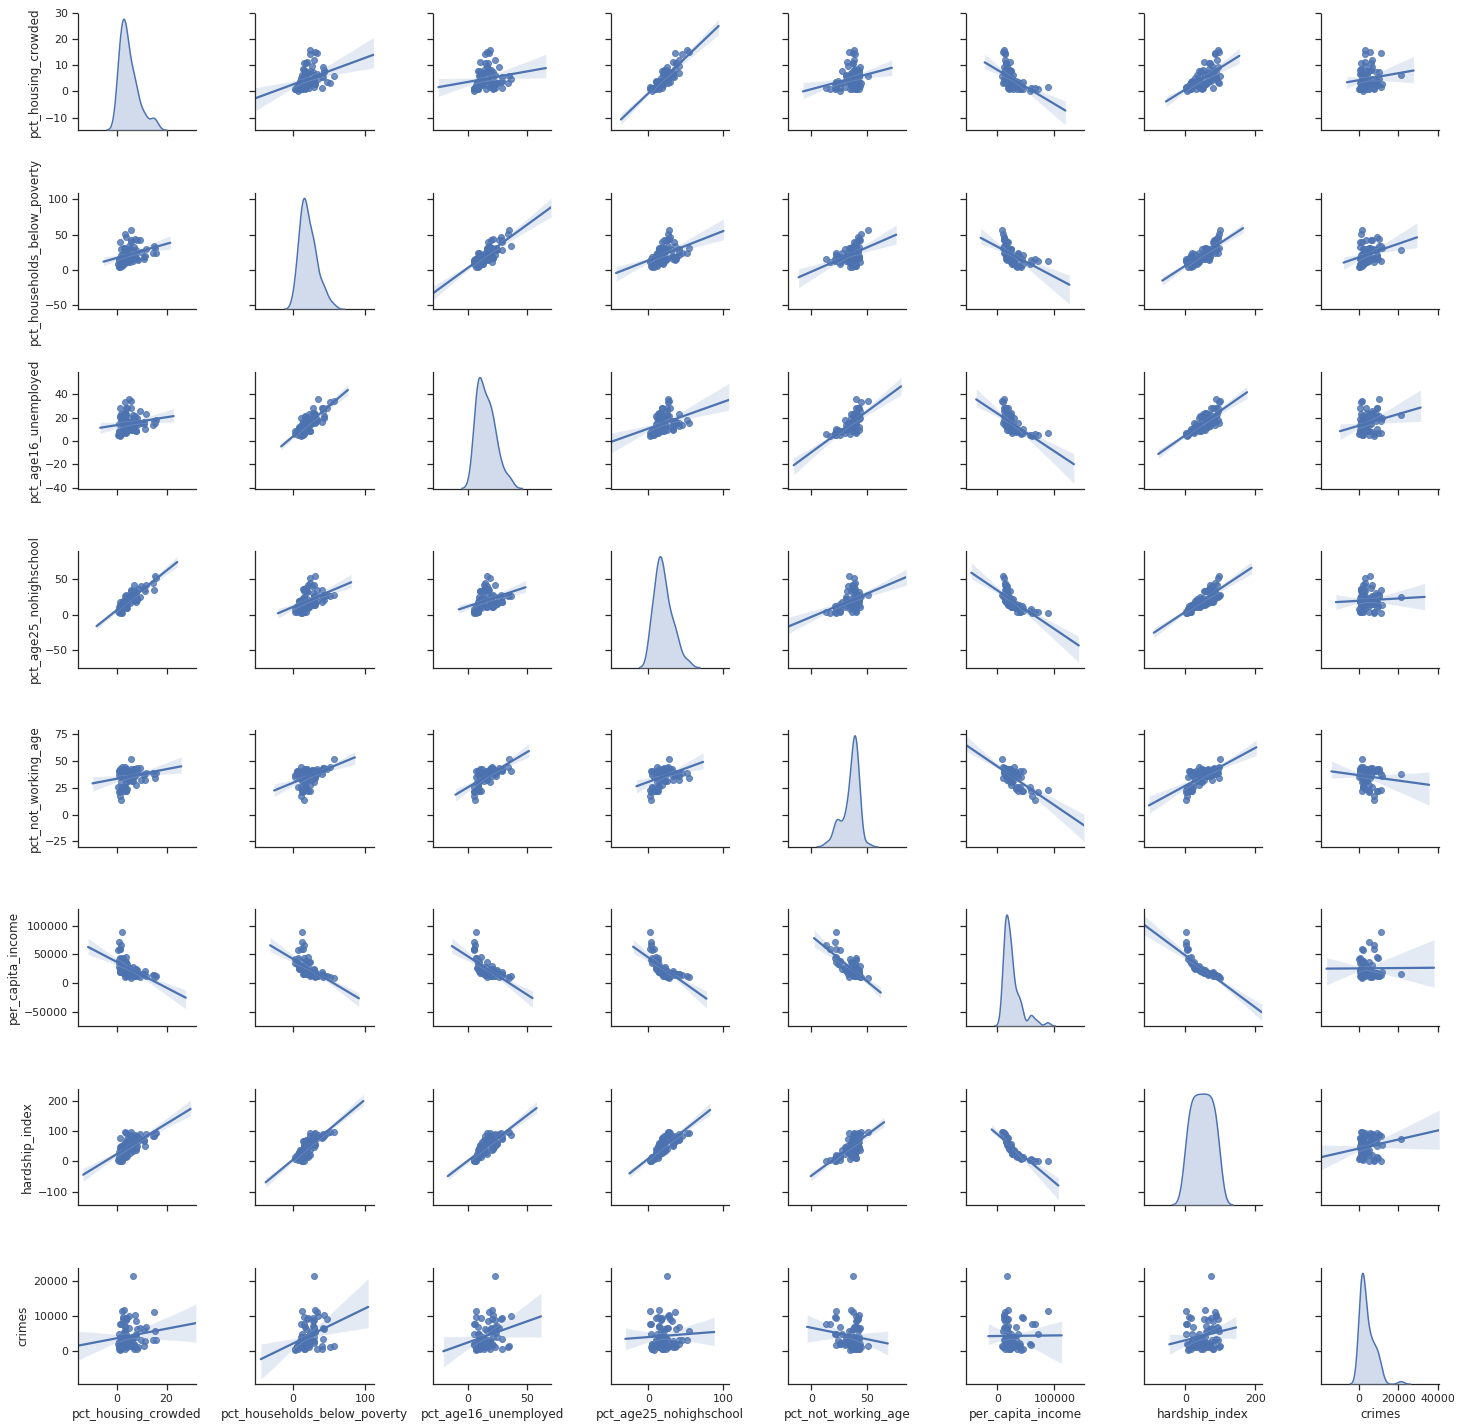

In [37]:
sns.set(style='ticks', color_codes=True)
sns.pairplot(chicri_commarea_df, diag_kind='kde', kind='reg')

**Rank the Community Areas by highest number of crimes**

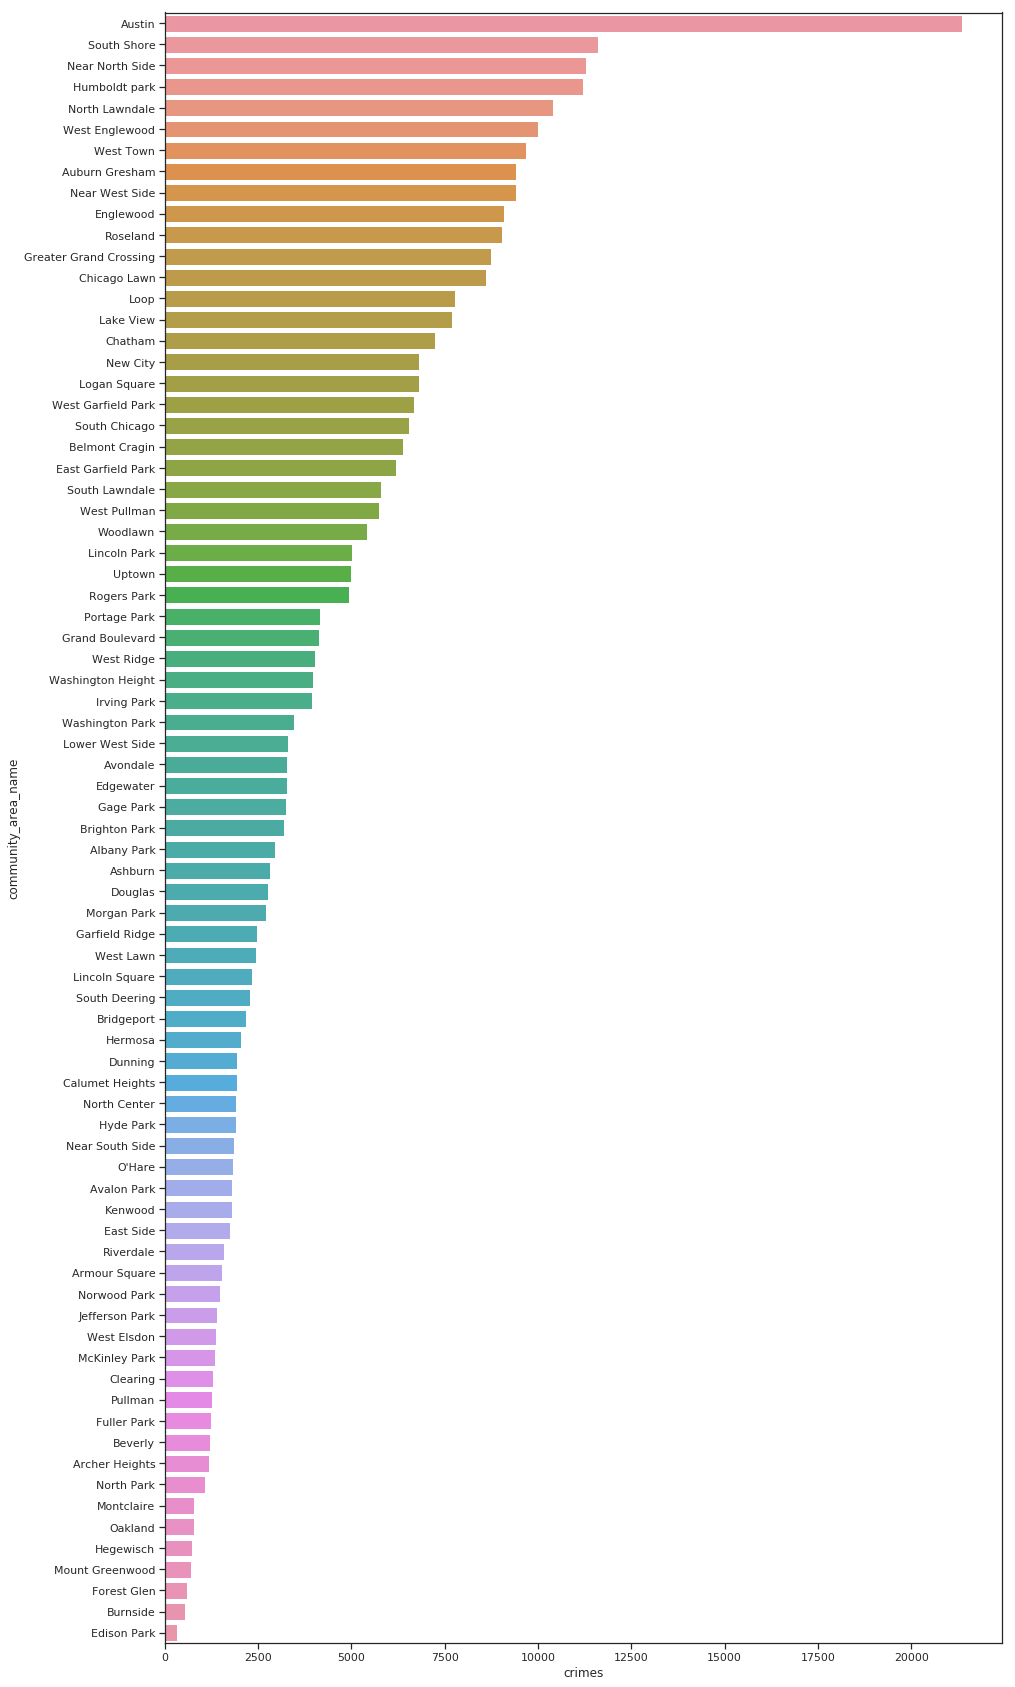

In [38]:
plt.figure(figsize=(15,30))
sns.barplot(x='crimes', y='community_area_name', data=chicri_commarea_df, ci=None)


**Query Total Crimes by Primary Crime Type**

In [39]:
city_sql_primtype = """
WITH cr AS
(
    SELECT DISTINCT
    primary_type
    , COUNT(*) AS crimes 
    FROM  `bigquery-public-data.chicago_crime.crime`
    WHERE year = 2012
    GROUP BY primary_type
)
SELECT 
cr.crimes
, cr.primary_type
FROM cr
ORDER BY  cr.crimes DESC, cr.primary_type
"""
chicri_primtype_df = chicago_crime.query_to_pandas(city_sql_primtype)

**Rank the Primary Crime Type by highest number of crimes**

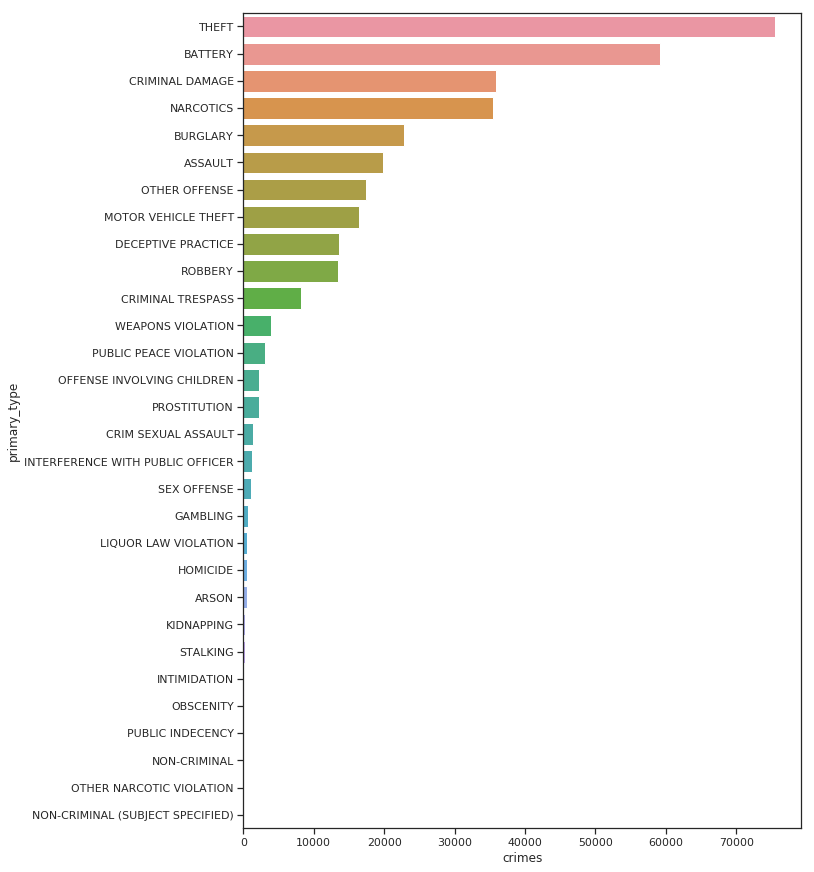

In [40]:
plt.figure(figsize=(10,15))
sns.barplot(x='crimes', y='primary_type', data=chicri_primtype_df, ci=None)


## Create the Model, Fit the Model, and Evaluate the Results

**Start with a new set of Crime Data**

In [41]:
city_commarea_month = """
WITH cr AS
(
    SELECT DISTINCT
    community_area
    , EXTRACT(MONTH FROM CAST(date AS DATE)) AS crime_month
    , primary_type
    , COUNT(*) AS crimes 
    FROM  `bigquery-public-data.chicago_crime.crime`
    WHERE year = 2012
    GROUP BY primary_type, community_area, crime_month
)
SELECT 
cr.crimes
, CAST(cr.crime_month AS STRING) AS crime_month
, cr.primary_type
, cr.community_area
FROM cr
ORDER BY cr.community_area, cr.crime_month, cr.primary_type
"""

city_data = chicago_crime.query_to_pandas(city_commarea_month)

**Merge with the Socio-Economic data**
Clean the data: Drop nan's, eliminate non features, assign correct type for One Hot Encoding

In [42]:
city_data = pd.merge(city_data, chipop_df, on='community_area', how='inner')
city_data = city_data.dropna(inplace=False)  
city_data = city_data.drop('community_area_name', 1)
city_data['community_area'] = city_data['community_area'].astype(str)


**One Hot Encoding all of the categorical columns**
* Month
* Community Area
* Primary Crime Type

In [43]:
city_data_with_dummies = pd.get_dummies(city_data)
city_data_with_dummies.head(1)

,crimes,pct_housing_crowded,pct_households_below_poverty,pct_age16_unemployed,pct_age25_nohighschool,pct_not_working_age,per_capita_income,hardship_index,crime_month_1,crime_month_10,crime_month_11,crime_month_12,crime_month_2,crime_month_3,crime_month_4,crime_month_5,crime_month_6,crime_month_7,crime_month_8,crime_month_9,primary_type_ARSON,primary_type_ASSAULT,primary_type_BATTERY,primary_type_BURGLARY,primary_type_CRIM SEXUAL ASSAULT,primary_type_CRIMINAL DAMAGE,primary_type_CRIMINAL TRESPASS,primary_type_DECEPTIVE PRACTICE,primary_type_GAMBLING,primary_type_HOMICIDE,primary_type_INTERFERENCE WITH PUBLIC OFFICER,primary_type_INTIMIDATION,primary_type_KIDNAPPING,primary_type_LIQUOR LAW VIOLATION,primary_type_MOTOR VEHICLE THEFT,primary_type_NARCOTICS,primary_type_NON-CRIMINAL,primary_type_NON-CRIMINAL (SUBJECT SPECIFIED),primary_type_OBSCENITY,primary_type_OFFENSE INVOLVING CHILDREN,...,community_area_43.0,community_area_44.0,community_area_45.0,community_area_46.0,community_area_47.0,community_area_48.0,community_area_49.0,community_area_5.0,community_area_50.0,community_area_51.0,community_area_52.0,community_area_53.0,community_area_54.0,community_area_55.0,community_area_56.0,community_area_57.0,community_area_58.0,community_area_59.0,community_area_6.0,community_area_60.0,community_area_61.0,community_area_62.0,community_area_63.0,community_area_64.0,community_area_65.0,community_area_66.0,community_area_67.0,community_area_68.0,community_area_69.0,community_area_7.0,community_area_70.0,community_area_71.0,community_area_72.0,community_area_73.0,community_area_74.0,community_area_75.0,community_area_76.0,community_area_77.0,community_area_8.0,community_area_9.0
13,20,7.7,23.6,8.7,18.2,27.5,23939,39.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Split the data between training and test**

In [44]:
city_crime_data = city_data_with_dummies.values
X = city_crime_data[:,1:].astype(float) 
Y = city_crime_data[:,0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

**Normalize the ordinal features in the independent variables:  between 0 and 1**

In [45]:

X_train[:,1] = X_train[:,1] / X_train[:,1].max()
X_train[:,2] = X_train[:,2] / X_train[:,2].max()
X_train[:,3] = X_train[:,3] / X_train[:,3].max()
X_train[:,4] = X_train[:,4] / X_train[:,4].max()
X_train[:,5] = X_train[:,5] / X_train[:,5].max()
X_train[:,6] = X_train[:,6] / X_train[:,6].max()
X_train[:,7] = X_train[:,7] / X_train[:,7].max()

X_test[:,1] = X_test[:,1] / X_test[:,1].max()
X_test[:,2] = X_test[:,2] / X_test[:,2].max()
X_test[:,3] = X_test[:,3] / X_test[:,3].max()
X_test[:,4] = X_test[:,4] / X_test[:,4].max()
X_test[:,5] = X_test[:,5] / X_test[:,5].max()
X_test[:,6] = X_test[:,6] / X_test[:,6].max()
X_test[:,7] = X_test[:,7] / X_test[:,7].max()


**Build the Model**

In [46]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dense(16, kernel_initializer='glorot_uniform', activation='relu'))  
model.add(Dense(8, kernel_initializer='glorot_uniform', activation='relu'))  
model.add(Dense(1, kernel_initializer='glorot_uniform'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


Instructions for updating:
Colocations handled automatically by placer.


**Fit the Model**

In [47]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=0, validation_split=.2)

Instructions for updating:
Use tf.cast instead.


**Visulaize the metrics - it appears that the model trained well**
Actually we could probably stop after 25 Epochs

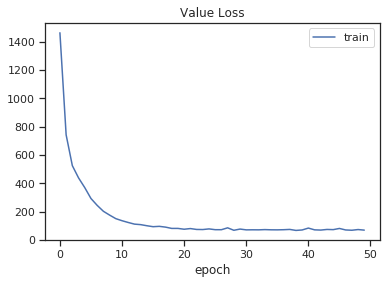

In [48]:
plt.plot(history.history['val_loss'])
plt.title('Value Loss')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

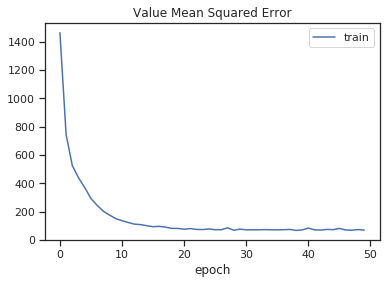

In [49]:
plt.plot(history.history['val_mean_squared_error'])
plt.title('Value Mean Squared Error')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

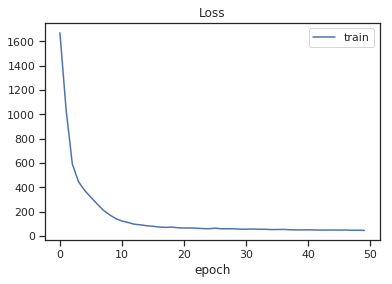

In [50]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

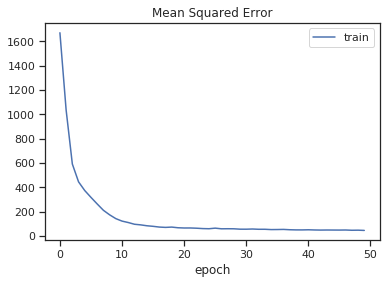

In [51]:
plt.plot(history.history['mean_squared_error'])
plt.title('Mean Squared Error')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Apply the Fitted Model to the test set and generate the Predicted Y variables - Number of Crimes by Month, Community Area, Primary Crime Type**
* Calculate the Root Mean Squared Error - Average error in the prediction expressed as number of crimes
* Calculate the R2 - Coeficient of Determination

In [52]:
pred_crimes = model.predict(X_test)
mse_pred_score = metrics.mean_squared_error(pred_crimes, Y_test)
print('mse_pred_score {}'.format(mse_pred_score))
rmse_pred_score = np.sqrt(mse_pred_score)
print('rmse_pred_score {}'.format(rmse_pred_score))
r2_pred_score = r2_score(Y_test, pred_crimes, multioutput='uniform_average')  
print('r2_pred_score - Coefficient of Determination {}'.format(r2_pred_score))


mse_pred_score 67.57679747209374
rmse_pred_score 8.220510779269969
r2_pred_score - Coefficient of Determination 0.952239601532606


**Plot the Predicted Y (Crimes) to the Actual Y (Crimes)**

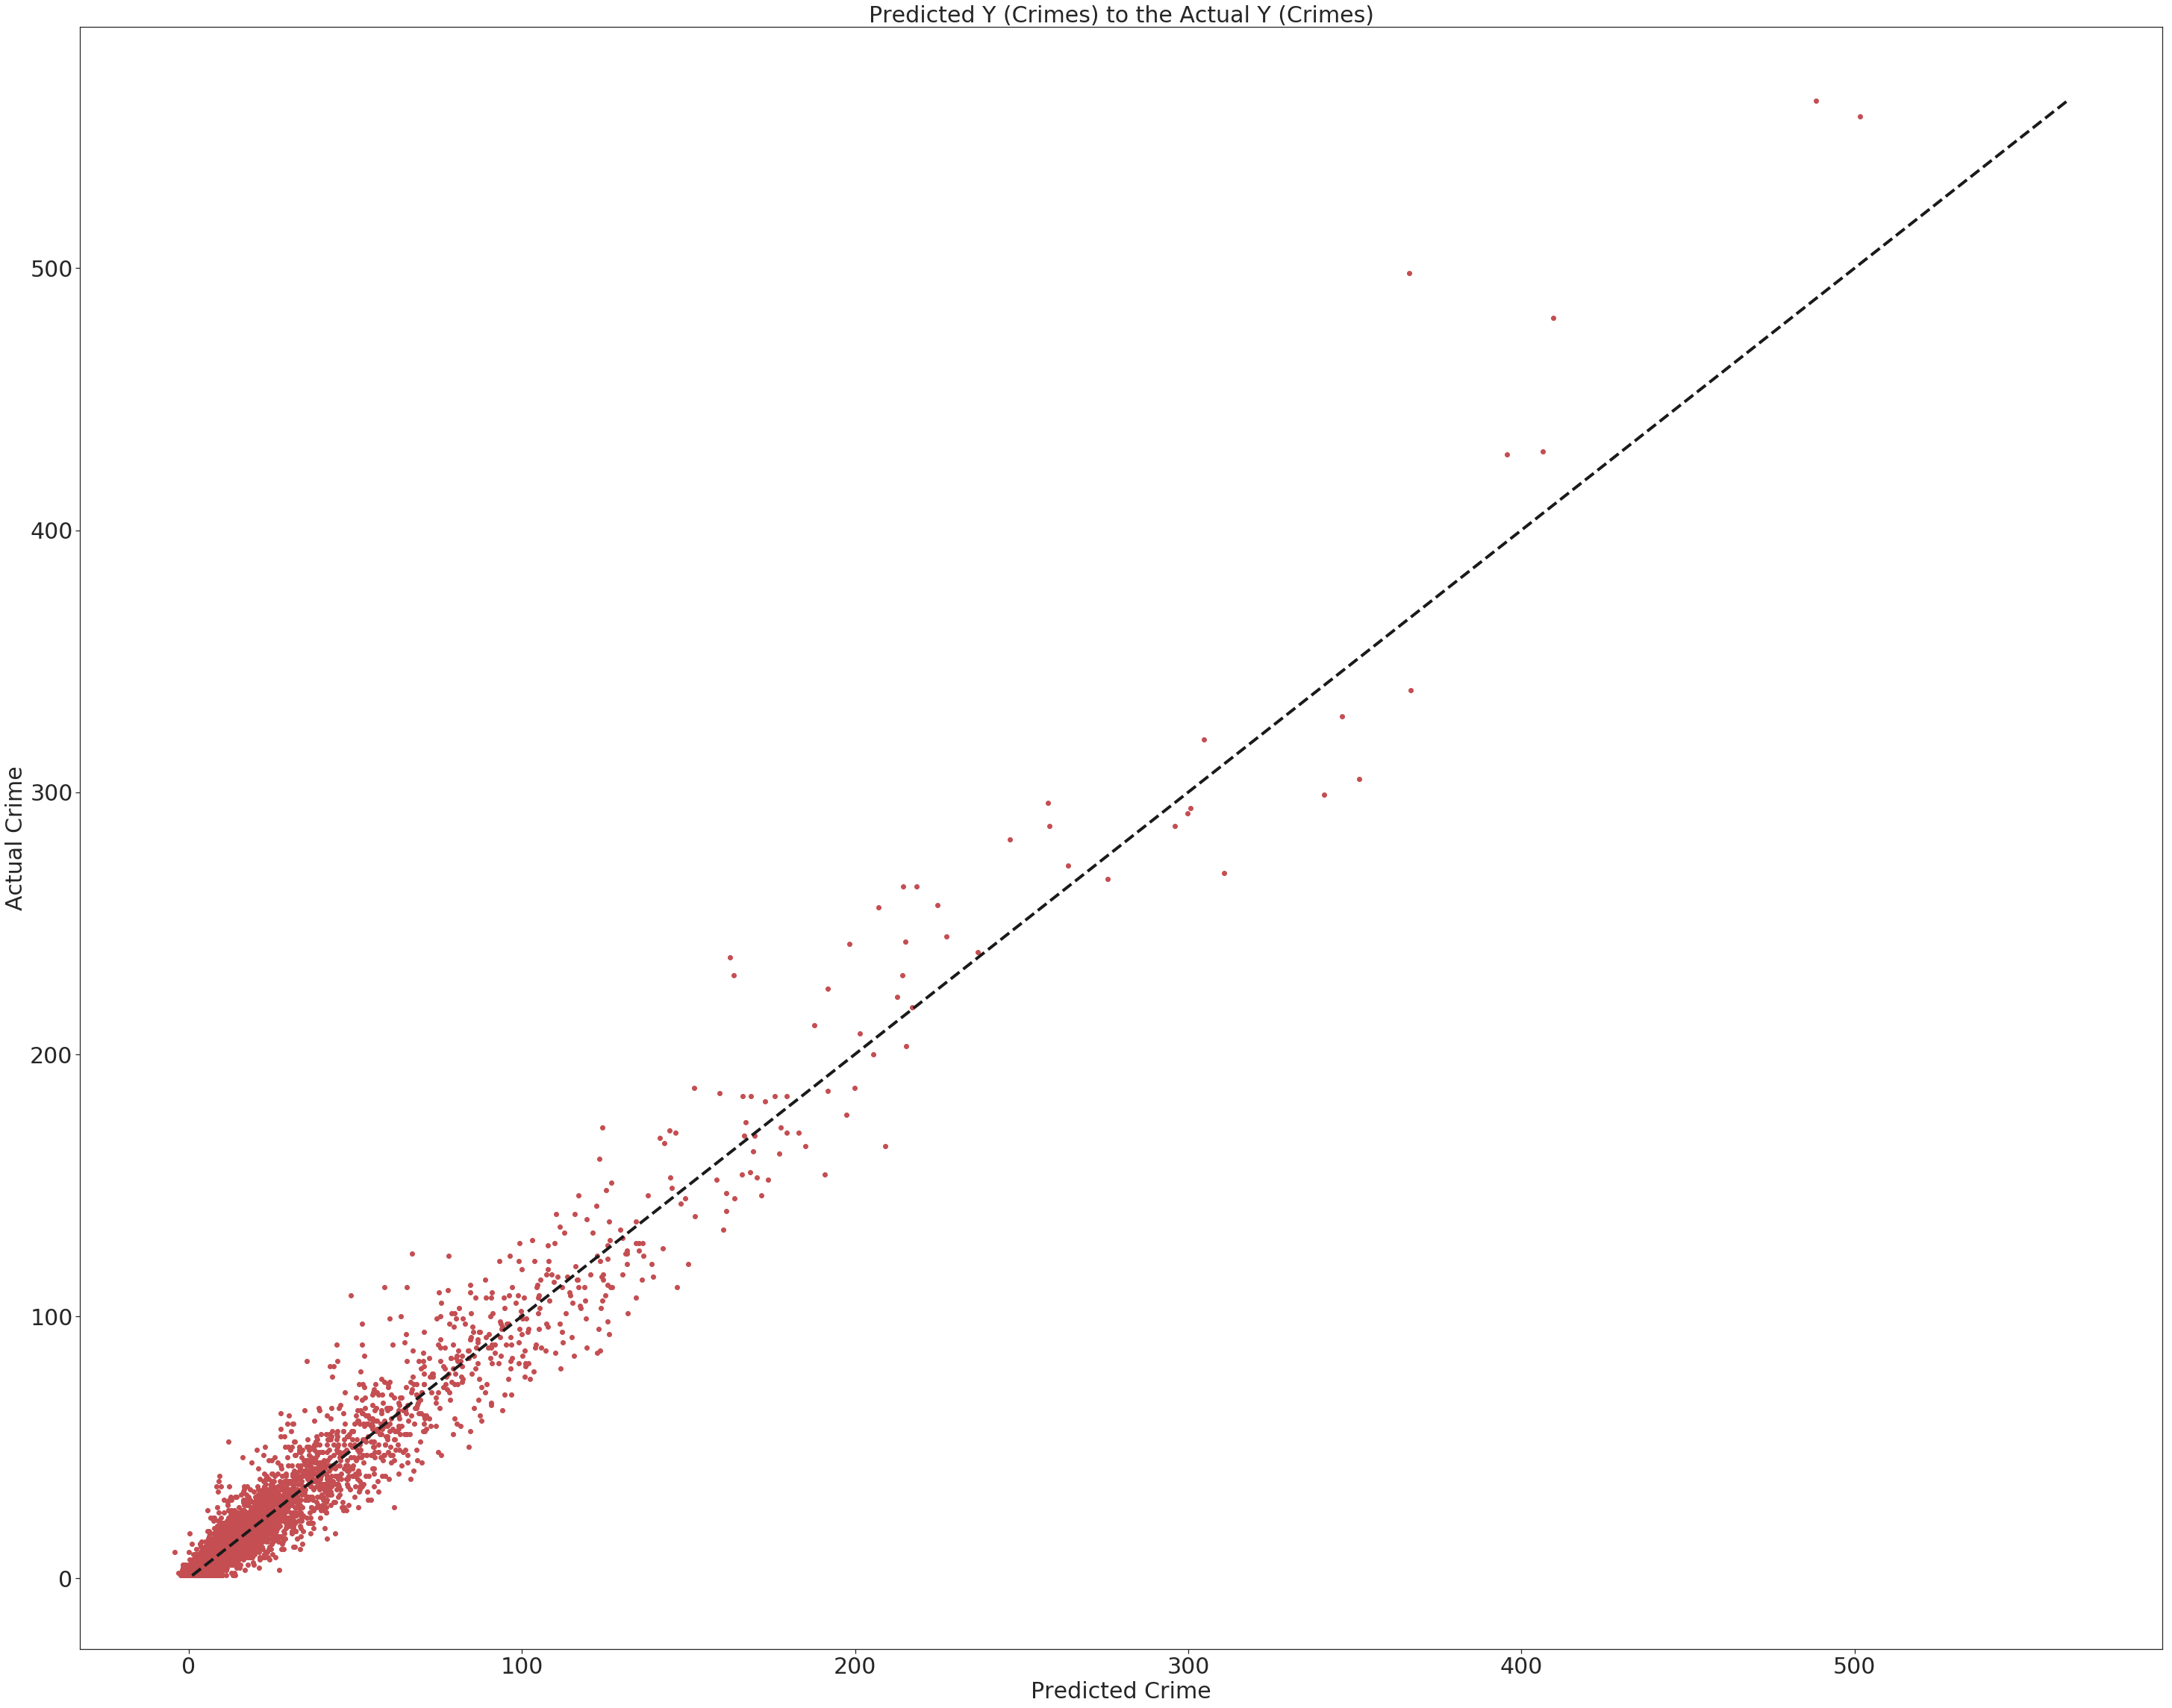

In [53]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 
fig, ax = plt.subplots(figsize=(50, 40))
plt.style.use('ggplot')
plt.plot(pred_crimes, Y_test, 'ro')
plt.xlabel('Predicted Crime', fontsize = 30)
plt.ylabel('Actual Crime', fontsize = 30)
plt.title('Predicted Y (Crimes) to the Actual Y (Crimes)', fontsize = 30)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
plt.show()